# Praca domowa nr4
Zuzanna Kotlińska, Agata Kopyt

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, precision_score, recall_score
from imblearn.combine import SMOTEENN

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings as wr
wr.filterwarnings("ignore")

## Wczytanie i podział danych

In [227]:
df = pd.read_csv('data.csv')

Jako, że nazwy kolumn zaczynają się od spacji, usuwamy ją.

In [228]:
df.columns = df.columns.str.lstrip()

In [229]:
def split_data(X,y, random_state = 42):
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, stratify=y_val, test_size=0.3, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [230]:
y = np.array(df['Bankrupt?'])
X = df.drop(['Bankrupt?'], axis=1)

In [231]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

## Preprocessing

Zobaczmy jak przedstawiają się nasze dane

In [232]:
X_train.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,...,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.0,4773.000000
mean,0.504262,0.557497,0.552759,0.607735,0.607715,0.998757,0.797263,0.809187,0.303747,0.781438,...,0.807204,1.980390e+07,0.623760,0.607733,0.840443,0.280316,0.027715,0.565339,1.0,0.047192
std,0.060874,0.065915,0.062145,0.017043,0.017025,0.014483,0.011973,0.010917,0.011899,0.011813,...,0.040504,3.865474e+08,0.012689,0.017043,0.009648,0.010208,0.018559,0.014131,0.0,0.049090
min,0.024277,0.000000,0.033514,0.000000,0.000000,0.000000,0.000000,0.084286,0.235090,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.344652,0.133503,0.000000,0.000000,1.0,0.000000
25%,0.476088,0.535052,0.527116,0.600463,0.600455,0.998969,0.797385,0.809310,0.303467,0.781566,...,0.796561,9.066675e-04,0.623635,0.600459,0.840095,0.276953,0.026791,0.565158,1.0,0.024383
50%,0.502462,0.559474,0.552010,0.605940,0.605904,0.999022,0.797462,0.809375,0.303525,0.781634,...,0.810467,2.069045e-03,0.623876,0.605936,0.841148,0.278794,0.026809,0.565254,1.0,0.033730
75%,0.534637,0.588149,0.582901,0.613651,0.613593,0.999093,0.797575,0.809467,0.303584,0.781729,...,0.826101,5.242451e-03,0.624168,0.613651,0.842336,0.281491,0.026914,0.565729,1.0,0.052676
max,1.000000,1.000000,1.000000,0.665151,0.666023,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,0.665149,1.000000,0.652347,1.000000,1.000000,1.0,1.000000


In [233]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 3295 to 6313
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   ROA(C) before interest and depreciation before interest  4773 non-null   float64
 1   ROA(A) before interest and % after tax                   4773 non-null   float64
 2   ROA(B) before interest and depreciation after tax        4773 non-null   float64
 3   Operating Gross Margin                                   4773 non-null   float64
 4   Realized Sales Gross Margin                              4773 non-null   float64
 5   Operating Profit Rate                                    4773 non-null   float64
 6   Pre-tax net Interest Rate                                4773 non-null   float64
 7   After-tax net Interest Rate                              4773 non-null   float64
 8   Non-industry income and e

### Braki danych
Sprawdzamy czy są braki danych

In [234]:
X_train.isna().mean(axis=0).any()

False

Sprawdzamy, czy są kolumny o tylko 1 unikalnej wartości

In [235]:
X_train.columns[X_train.nunique() == 1]

Index(['Net Income Flag'], dtype='object')

Taką kolumną jest `Net Income Flag`. Usuniemy ją, bo jako stała nie ma wpływu na zmienną celu.

In [236]:
X_train =X_train.drop(['Net Income Flag'], axis=1)
X_val =X_val.drop(['Net Income Flag'], axis=1)

### Rozkład zmiennej celu

In [237]:
np.unique(y_train)

array([0, 1], dtype=int64)

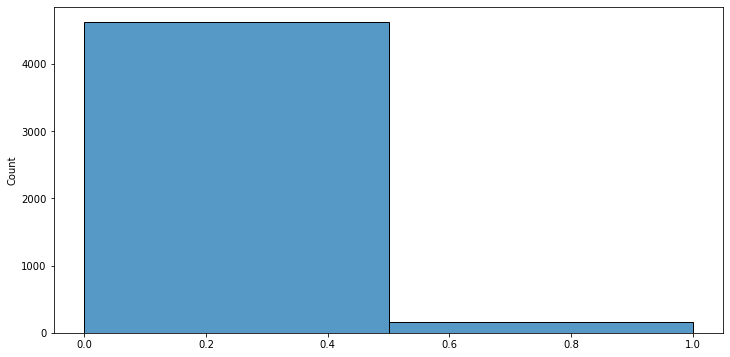

In [238]:
plt.figure(figsize=(12,6))
sns.histplot(data = y_train, bins=2)
plt.show()

### Zbilansowanie

Zmienna celu jest nie zbilansowana, w związku z tym postaramy się sztucznie to poprawić używając *SMOTEENN*. Jest to połączenie oversamplingu z wykorzystaniem SMOTE i undersamplingu z użyciem ENN. Poprawiając dysproporcję nie dążymy, aby wartości zmiennej celu były wyrównane, ponieważ za bardzo odbiega to od rzeczywistości.

In [239]:
resample = SMOTEENN(random_state=42,sampling_strategy=0.2)
X_train, y_train = resample.fit_resample(X_train, y_train)

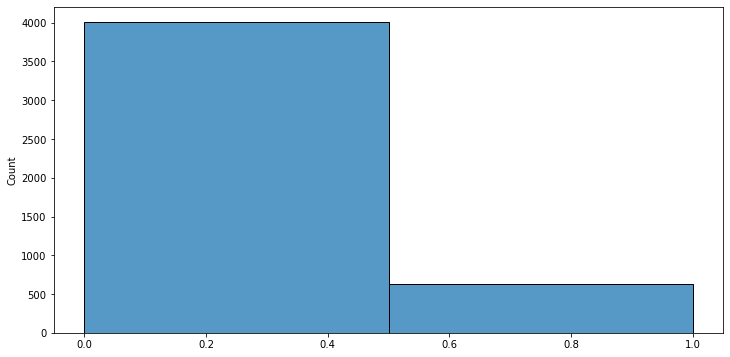

In [240]:
plt.figure(figsize=(12,6))
sns.histplot(data = y_train, bins=2)
plt.show()

### Outliery
Sprawdźmy teraz występowanie outlierów

In [241]:
def count_outliers(X : pd.DataFrame, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((X[column] < (Q1 - 1.5 * IQR)) | (X[column] > (Q3 + 1.5 * IQR))).sum()
    major_outlier_count = ((X[column] < (Q1 - 3 * IQR)) | (X[column] > (Q3 + 3 * IQR))).sum()
    return outlier_count, major_outlier_count

In [242]:
outliers_df = pd.DataFrame(columns=['Column', 'Outliers', 'Major Outliers'])
for column in X_train.columns:
    outlier_count, major_outlier_count = count_outliers(X_train, column)
    outliers_df = outliers_df.append({'Column': column, 'Outliers': outlier_count, 'Major Outliers': major_outlier_count}, ignore_index=True)
outliers_df

,Column,Outliers,Major Outliers
0,ROA(C) before interest and depreciation before...,291,61
1,ROA(A) before interest and % after tax,357,114
2,ROA(B) before interest and depreciation after tax,330,86
3,Operating Gross Margin,213,57
4,Realized Sales Gross Margin,217,56
...,...,...,...
89,Net Income to Stockholder's Equity,464,232
90,Liability to Equity,304,100
91,Degree of Financial Leverage (DFL),1152,763
92,Interest Coverage Ratio (Interest expense to E...,1066,648


Jak widać outliery istotnie występują, zostaną więc przycięte.

In [243]:
def TrimOutliers(X):
    for column in X.columns:
        if not is_numeric_dtype(X[column]):
            continue
        min_v = X[column].quantile(0.025)
        max_v = X[column].quantile(0.975)
        X.loc[X[column] < min_v, column] = min_v
        X.loc[X[column] > max_v, column] = max_v
    return X

In [244]:
X_train = TrimOutliers(X_train)
X_val = TrimOutliers(X_val)

### Zmienne skorelowane ze zmienną celu
Teraz szukamy zmiennych silnie skorelowanych ze zmienną celu. Wznaczamy feature importance dla każdej zmiennej i dla zmiennych o korelacji >0.65 usuwamy zmienną mniej informatywną.

In [245]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index = X_train.columns)

In [246]:
def remove_highly_correlated(X, mi, threshold=0.65):
    # znajdź pary (różnych) zmiennych o korelacji większej niż threshold
    correlation = X.corr()
    correlation = correlation.melt(ignore_index=False).reset_index(drop=False).rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})
    correlation = correlation[(np.abs(correlation['Corr']) > threshold) & (correlation['Var 1'] != correlation['Var 2'])].sort_values(by='Corr', ascending=False)

    # idąc od najbardziej skorelowanych odrzuć tę mniej ważną
    # jest to bardzo prosty i naiwny algorytm, ponieważ nie maksymalizuje on średniej pozostałej wartości feature importance
    # ani nie minimalizuje liczby usuniętych zmiennych

    removed_features = set()
    for _, row in correlation.iterrows():
        var_1 = row['Var 1']
        var_2 = row['Var 2']
        if (var_1 in removed_features or var_2 in removed_features):
            continue # do not remove unecessary columns
        fi_1 = mi[var_1]
        fi_2 = mi[var_2]
        if (fi_2 < fi_1):
            removed_features.add(var_2)
        else:
            removed_features.add(var_1)

    return X.drop(list(removed_features), axis=1), removed_features

Poniższy wykres przedstawia feature importance dla 10 najlepszych zmiennych.

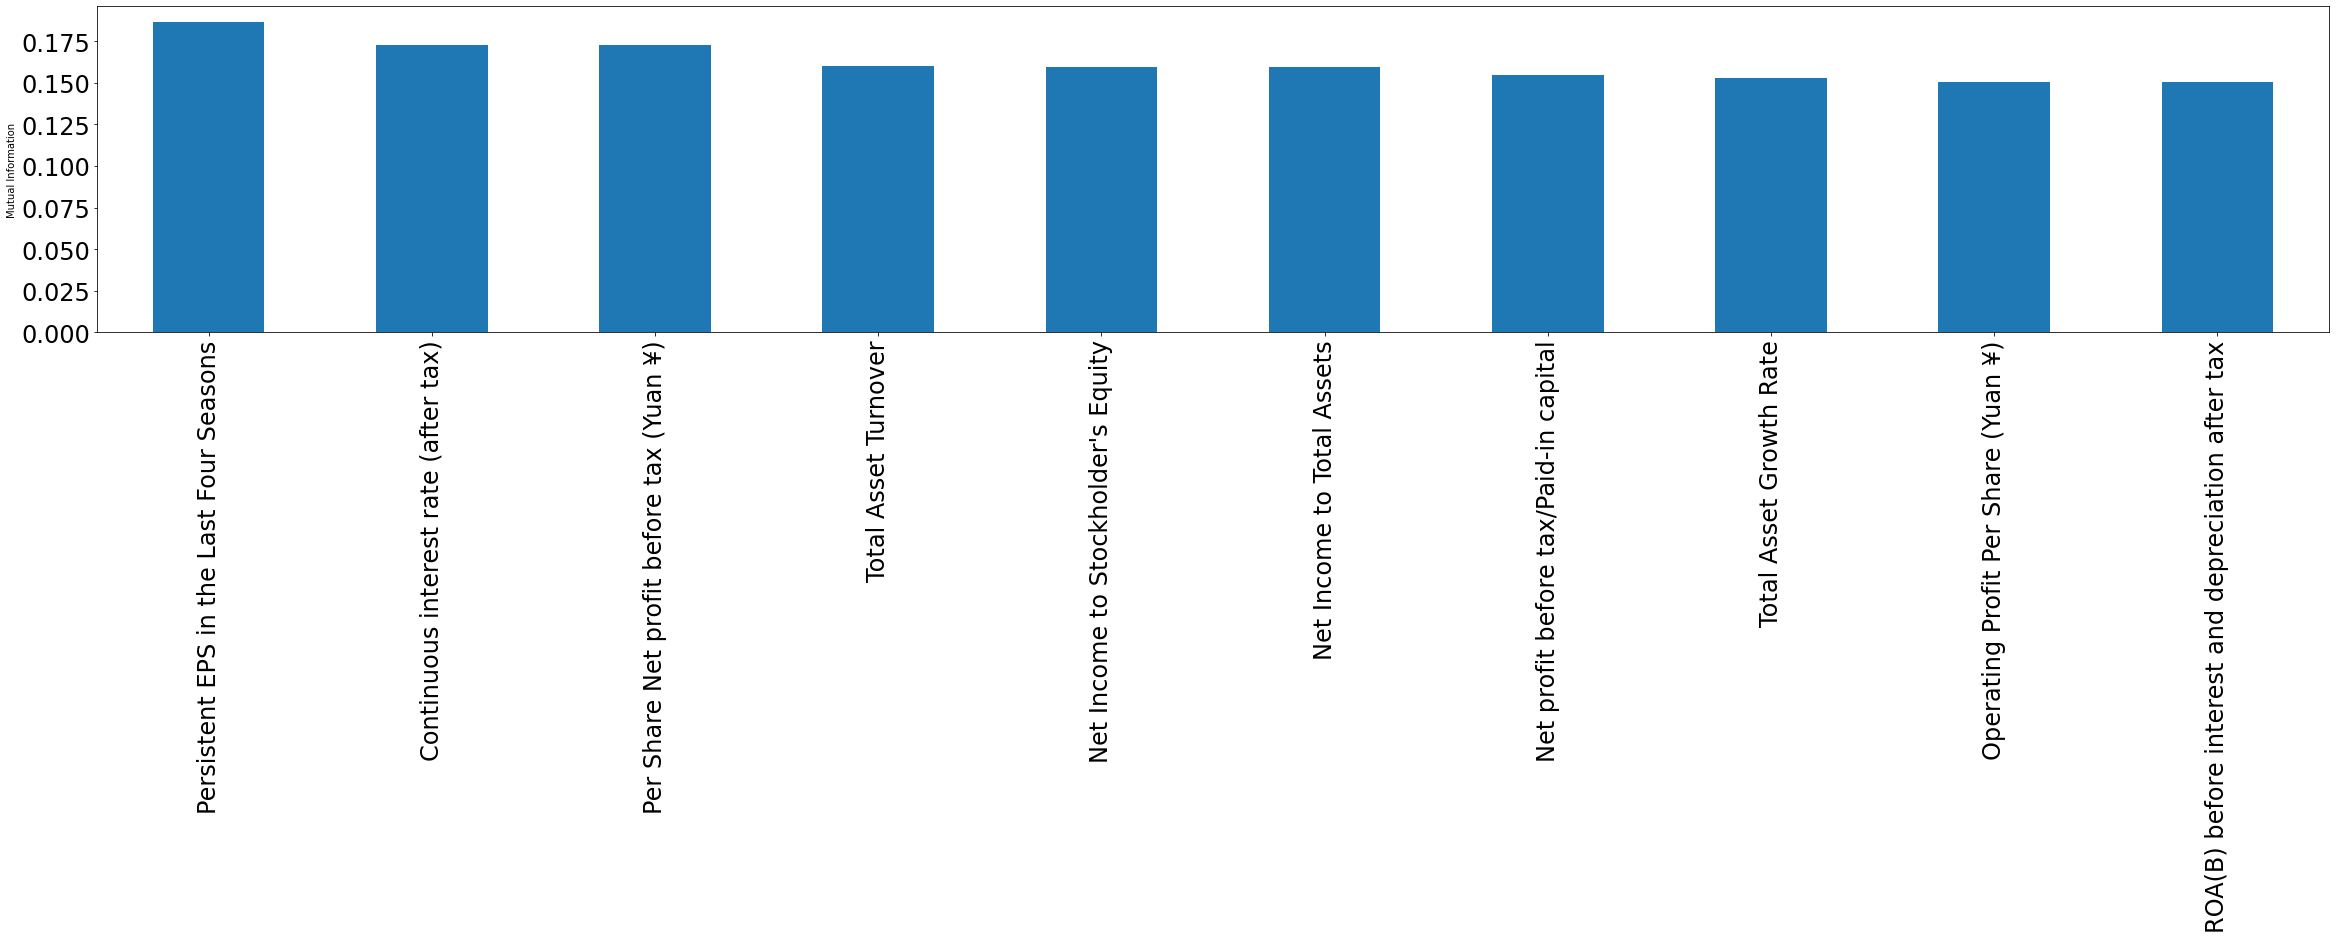

In [247]:
plt.figure(figsize=(40, 6))
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index = X_train.columns)
top_10_features = mi.sort_values(ascending=False).head(10)
top_10_features.plot.bar(fontsize=24)
plt.ylabel('Mutual Information')
plt.show()

Po usunięciu zmiennych silnie skorelowanych, wybierzemy 30 najlepszych zmiennych do trenowania modeli.

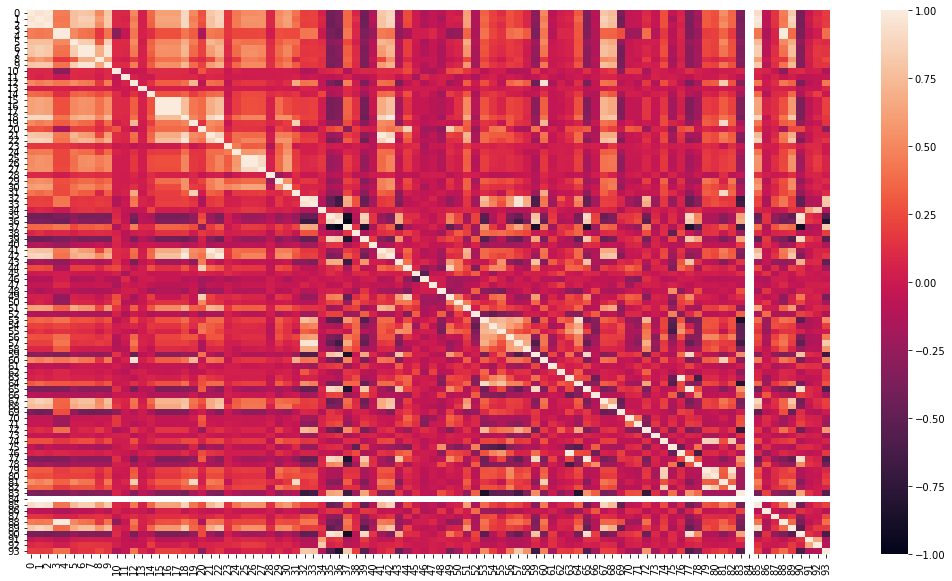

In [248]:
plt.figure(figsize=(18, 10))
sns.heatmap(X_train.corr(), vmin=-1, vmax=1,
        xticklabels=np.arange(X_train.columns.shape[0]), # liczby dla czytelności, poniważ nazwy kolumn są zbyt długie
        yticklabels=np.arange(X_train.columns.shape[0]))
plt.show()

In [249]:
class CorrelatedFeatureDropper:
    def __init__(self, threshold=0.65):
        self.threshold = threshold

    def fit(self, X, y):
        mi = mutual_info_classif(X, y)
        mi = pd.Series(mi, index=X.columns)
        self.dropped_columns = remove_highly_correlated(X, mi)[1]
        return self

    def transform(self, X, y = None):
        return X.drop(self.dropped_columns, axis=1)

### Zamiana korelacji ujemnej na dodatnią

In [250]:
def Negative2Positive(X,y):
    X['Bankrupt?'] = y
    correlation = X.corr()
    negativ_corr = X.columns[correlation['Bankrupt?']<0] #lista zmiennych ujemnie skorelowanych
    for column in negativ_corr:
        X[column] = -X[column] #zmaiana wartosći tych zmiennych na przeciwne
    return X.drop('Bankrupt?', axis=1)

In [251]:
X_train = Negative2Positive(X_train, y_train)
X_val =Negative2Positive(X_val, y_val)

### Przeskalowanie zmiennych i wybór 30 najbardziej informatywnych

In [252]:
preprocessor = Pipeline(
    steps=[
        ('CorrelatedFeatureDropper', CorrelatedFeatureDropper()),
        ('MinMaxScaler', MinMaxScaler()),
        ('FeatureSelector', SelectKBest(mutual_info_classif, k=30)),
    ]
)

X_train= preprocessor.fit_transform(X_train,y_train)
X_val=preprocessor.transform(X_val)

## Budowanie modeli

Najpierw stworzymy uniwerslaną funkcję do ewaluacji modeli z metryką accuracy, precision, recall i F1 Score, przy czym strojenie parametru oparłyśmy o F1. Zdecydowałyśmy się na tą metrykę, ponieważ zmiena celu jest nie zbilansowana.

In [253]:
def evaluate(model : Pipeline, X, y, suppress_output = False):
    y_pred = model.predict(X)
    if not suppress_output:
        print(f"Accuracy score: ", accuracy_score(y,y_pred))
        print("precision: ", precision_score(y,y_pred))
        print("recall: ", recall_score(y,y_pred))
        print("f1: ", f1_score(y,y_pred))
        sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")

    return f1_score(y,y_pred)

### Drzewo decyzyjne

#### Model z parametrami domyślnymi

Accuracy score:  0.8505586592178771
precision:  0.08415841584158416
recall:  0.3695652173913043
f1:  0.1370967741935484


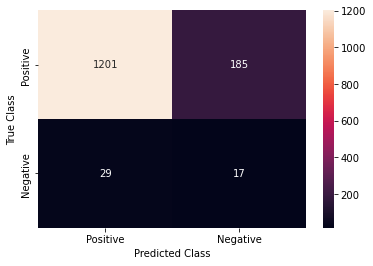

In [254]:
from sklearn.tree import DecisionTreeClassifier
#parametry domyślne
tree_model= DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)
tree_model_f1 = evaluate(tree_model, X_val, y_val)

#### Model ze strojeniem

Drzewo decyzyjne przyjmjuje następujące parametry:

In [255]:
tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Zdecydowałyśmy dostroić parametry `max_depth`, `min_samples_split`, `criterion`.

In [256]:
max_depth=np.arange(10,150,10)
max_depth =np.append(max_depth,None)
min_samples_split=np.arange(1,10,1)
criterion=["gini","entrophy"]
decision_grid = dict(max_depth=max_depth,min_samples_split= min_samples_split, criterion=criterion)

##### Random Search

In [257]:
random = RandomizedSearchCV(estimator=tree_model, param_distributions=decision_grid, n_jobs=-1, scoring = 'f1')

tree_random_result = random.fit(X_train, y_train)

#Podsumowanie wyników
print("Best: %f using %s" % (tree_random_result.best_score_, tree_random_result.best_params_))

Best: 0.790349 using {'min_samples_split': 4, 'max_depth': 60, 'criterion': 'gini'}


Accuracy score:  0.8547486033519553
precision:  0.095
recall:  0.41304347826086957
f1:  0.15447154471544716


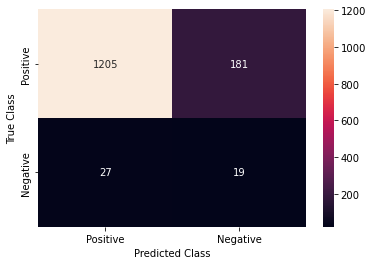

In [258]:
tree_random = tree_random_result.best_estimator_
tree_random_f1 = evaluate(tree_random, X_val, y_val)

##### Grid Search

In [259]:
grid = GridSearchCV(estimator=tree_model, param_grid=decision_grid, n_jobs=-1, scoring = 'f1', cv=3)

tree_grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (tree_grid_result.best_score_, tree_grid_result.best_params_))

Best: 0.784576 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}


Accuracy score:  0.8512569832402235
precision:  0.08040201005025126
recall:  0.34782608695652173
f1:  0.13061224489795917


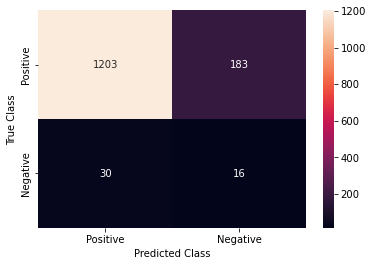

In [260]:
tree_grid= tree_grid_result.best_estimator_
tree_grid_f1 = evaluate(tree_grid,X_val,y_val)

### Random Forest

#### Model z parametrami domyślnymi

Accuracy score:  0.9727653631284916
precision:  0.6296296296296297
recall:  0.3695652173913043
f1:  0.4657534246575342


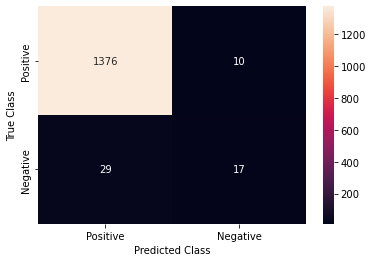

In [261]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
rf_f1 = evaluate(rf, X_val, y_val)

#### Model ze strojeniem

In [262]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Zdecydowałyśmy dostroić parametry `n_estimators`, `criterion` , `min_samples_split`.

In [263]:
n_estimators =[10,100,1000]
criterion=["gini","entrophy"]
min_samples_split = np.arange(1,10,1)
random_grid = dict(n_estimators=n_estimators,criterion=criterion, min_samples_split=min_samples_split )

##### Random Search

In [265]:
random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_jobs=-1, scoring = 'f1')

rf_random_result = random.fit(X_train, y_train)

#Podsumowanie wyników
print("Best: %f using %s" % (rf_random_result.best_score_, rf_random_result.best_params_))

Best: 0.902473 using {'n_estimators': 1000, 'min_samples_split': 2, 'criterion': 'gini'}


Accuracy score:  0.9720670391061452
precision:  0.59375
recall:  0.41304347826086957
f1:  0.4871794871794871


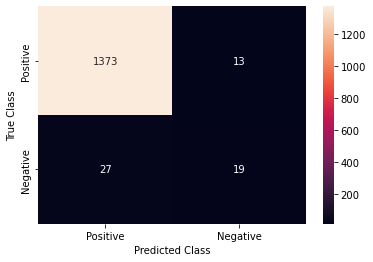

In [266]:
rf_random = rf_random_result.best_estimator_
rf_random_f1 = evaluate(rf_random, X_val, y_val)

##### Grid Search

In [267]:
grid = GridSearchCV(estimator=rf, param_grid=random_grid, n_jobs=-1, scoring = 'f1', cv=3)

rf_grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

Best: 0.888766 using {'criterion': 'gini', 'min_samples_split': 4, 'n_estimators': 100}


Accuracy score:  0.9706703910614525
precision:  0.5625
recall:  0.391304347826087
f1:  0.46153846153846156


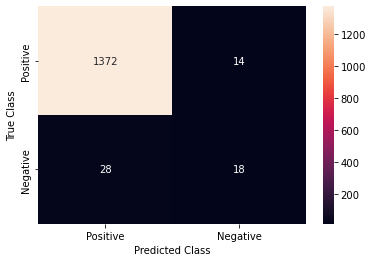

In [268]:
rf_grid= rf_grid_result.best_estimator_
rf_grid_f1 = evaluate(rf_grid,X_val,y_val)

### Support Vector Machine 

#### Model z parametrami domyślnymi

Accuracy score:  0.9678770949720671
precision:  0.0
recall:  0.0
f1:  0.0


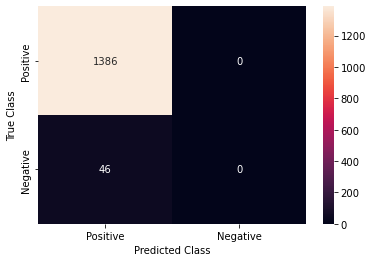

In [269]:
from sklearn.svm import SVC
svm = SVC(random_state=0)
svm.fit(X_train,y_train)
svm_f1 = evaluate(svm, X_val, y_val)

#### Model ze strojeniem

In [270]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Zdecydowałyśmy dostroić parametry `kernel`, `C` ,`gamma`.

##### Random Search

In [276]:
kernel = ['linear', 'poly', 'rbf']
C = [0.1, 1, 10, 100, 1000]
gamma = [1,0.1,0.01,0.001]
svm_grid = dict(kernel=kernel, C=C, gamma=gamma)

In [272]:
random = RandomizedSearchCV(estimator=svm, param_distributions=svm_grid, n_jobs=-1, scoring = 'f1')

svm_random_result = random.fit(X_train, y_train)

#Podsumowanie wyników
print("Best: %f using %s" % (svm_random_result.best_score_, svm_random_result.best_params_))

Best: 0.927970 using {'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}


Accuracy score:  0.9678770949720671
precision:  0.0
recall:  0.0
f1:  0.0


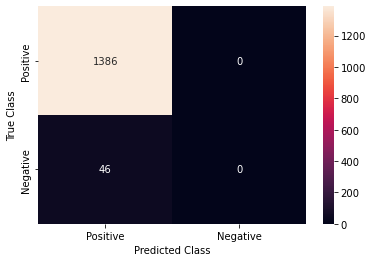

In [273]:
svm_random = svm_random_result.best_estimator_
svm_random_f1 = evaluate(svm_random, X_val, y_val)

##### Grid Search

In [274]:
grid = GridSearchCV(estimator=svm, param_grid=svm_grid, n_jobs=-1, scoring = 'f1', cv=3)

svm_grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (svm_grid_result.best_score_, svm_grid_result.best_params_))

Best: 0.942192 using {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


Accuracy score:  0.9678770949720671
precision:  0.0
recall:  0.0
f1:  0.0


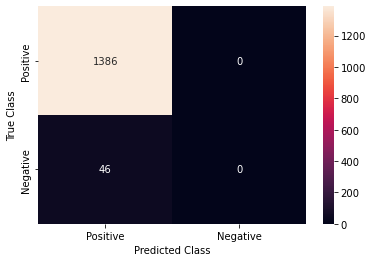

In [275]:
svm_grid= svm_grid_result.best_estimator_
svm_grid_f1 = evaluate(svm_grid,X_val,y_val)

## Podsumowanie

Jako że w zmiennej celu jest dysproporcja między ilością wartości pozytywnych do negatywnych, nie łatwo było poprawić wyniki F1 score za pomocą strojenia parametrów. Poprawa zbilansowania danych treningowych zaowocowała wyższym F1 score dla parametórw domyślnych. Na podstawie wyników wnioskujemy:
+ Model SVM nie sprawdził się do przewidywania danych, jako że F1 wyniosło 0, zarówno dla paramtrów domyślnych jak i po strojeniu
+ Dla drzewa decyzyjnego i Random Forest, Random Search uzyskał trochę lepsze wyniki od parametrów domyślnych,a qyniki z Grid Search były nieznacznie niższe od wyników z parametrami domyślnymi.
+ Drzewo decyzyjne otrzymało wyniki poniżej 0.2, w związku z tym model ten uważamy za nienajlepsze rozwiązanie
+ Najlepiej wypadł Random Forest, dla którego F1 wyniosło (po zastosowaniu Random Search) 0.5
+ Modele dobrze przewidywały wartości pozytywne, a miały problemy z negatywnymi - stąd niskie wyniki dla F1 score, przy wysokim accuracy. W związku z tym podejrzewamy, że wyniki możnaby poprawić jeszcze lepszym zbilansowaniem zmiennej celu.
+ Random Search wypadł lepiej od Grid Search pod względem prędkości działania oraz (choć nieznacznie) lepiej dopasowanych parametrów.